In [1]:
import random
from alpaca.utils.datasets.builder import build_dataset
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.special import logsumexp

In [2]:

def manual_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

manual_seed(42)


In [3]:
T = 10000
dataset = build_dataset('boston_housing', val_split=0)
x, y = dataset.dataset('train')
dropout_value = 0.005
lengthscale = 1e-2
N = x.shape[0] * 0.9 # train size
tau = 1e-3
reg = lengthscale**2 * (1 - dropout_value) / (2. * N * tau)

class Network(nn.Module):
    def __init__(self, input_size, dropout_value):
        super().__init__()
        self.dropout_0 = nn.Dropout(dropout_value)
        self.fc1 = nn.Linear(input_size, 50)
        self.dropout_1 = nn.Dropout(dropout_value)
        self.fc2 = nn.Linear(50, 50)
        self.dropout_2 = nn.Dropout(dropout_value)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.dropout_0(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.fc3(x)
        return x

def loader(x_array, y_array, batch_size=32):
    dataset = TensorDataset(torch.Tensor(x_array), torch.Tensor(y_array))
    return DataLoader(dataset, batch_size=batch_size)

def rmse(values, predictions):
    return np.sqrt(np.mean(np.square(values - predictions)))


def rmse_nll(model, T, x_test, y_test, y_scaler, tau, dropout=True):
    y_test_unscaled =  y_scaler.inverse_transform(y_test)
    if dropout:
        model.train()
    else:
        model.eval()

    with torch.no_grad():
        y_hat = np.array([y_scaler.inverse_transform(model(torch.Tensor(x_test)).numpy()) for _ in range(T)])
    y_pred = np.mean(y_hat, axis=0)
    ll = np.mean((logsumexp(-0.5 * tau * (y_test_unscaled[None] - y_hat)**2., 0) - np.log(T)
            - 0.5*np.log(2*np.pi) + 0.5*np.log(tau)))
    return rmse(y_test_unscaled, y_pred), ll


In [4]:

def split_and_scale(x, y):
    # Load dat
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.01)

    # Scaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)

    return x_train, y_train, x_test, y_test, y_scaler


def build_and_train(x_train, y_train, epochs, tau, dropout_value):
    reg = lengthscale**2 * (1 - dropout_value) / (2. * N * tau)
    train_loader = loader(x_train, y_train)

    model = Network(x_train.shape[1], dropout_value)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=reg)
    criterion = nn.MSELoss()
    train_losses = []

    for epoch in range(epochs):
        losses = []
        for x_batch, y_batch in train_loader:
            preds = model(x_batch)
            optimizer.zero_grad()
            loss = criterion(y_batch, preds)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if epoch % 10 == 0:
            train_losses.append(np.mean(losses))
    return model



In [5]:
x_train, y_train, x_test, y_test, y_scaler = split_and_scale(x, y)
results = []
for local_tau in np.logspace(-5, 1, 25):
    for local_dropout in [0.05]:
        model = build_and_train(x_train, y_train, 50, local_tau, local_dropout)
        error, ll = rmse_nll(model, 1, x_test, y_test, y_scaler, dropout=False, tau=local_tau)
        results.append((ll, error, (local_tau, local_dropout)))

best_tau, best_dropout = sorted(results, key=lambda p: p[0])[-1][-1]
print(results)
print(best_tau, best_dropout)


[(-6.675448873808338, 3.0857128366536783, (1e-05, 0.05)), (-6.387675005513413, 3.300837168997131, (1.778279410038923e-05, 0.05)), (-6.09990081434404, 3.0368712368782007, (3.1622776601683795e-05, 0.05)), (-5.812097916199857, 2.4302335674541498, (5.623413251903491e-05, 0.05)), (-5.524479515087151, 2.7232182960178744, (0.0001, 0.05)), (-5.236807133658474, 2.4219402597315343, (0.00017782794100389227, 0.05)), (-4.949427584313061, 2.4706418205214153, (0.00031622776601683794, 0.05)), (-4.662248374263358, 2.392223676078223, (0.0005623413251903491, 0.05)), (-4.376262583787284, 2.6254184777074583, (0.001, 0.05)), (-4.091262295556156, 2.6553582381937524, (0.0017782794100389228, 0.05)), (-3.8098687534943236, 2.8339831496628505, (0.0031622776601683794, 0.05)), (-3.5358252836819495, 3.0687524648234885, (0.005623413251903491, 0.05)), (-3.250685762465994, 2.4150418740583413, (0.01, 0.05)), (-3.000295173959289, 2.7367478169388013, (0.01778279410038923, 0.05)), (-2.7712274274404116, 2.815641100214362, (

In [6]:
vanilla_rmse = []
vanilla_ll = []
mc_rmse = []
mc_ll = []

for i in range(1):
    print(i)
    x_train, y_train, x_test, y_test, y_scaler = split_and_scale(x, y)
    model = build_and_train(x_train, y_train, 400, best_tau, best_dropout)

    model.eval()
    with torch.no_grad():
        test_loss = rmse(
            y_scaler.inverse_transform(y_test),
            y_scaler.inverse_transform(model(torch.Tensor(x_test)).numpy())
        )
    error, ll = rmse_nll(model, 1, x_test, y_test, y_scaler, tau=best_tau, dropout=False)
    vanilla_rmse.append(test_loss)
    vanilla_ll.append(ll)
    error, ll = rmse_nll(model, T, x_test, y_test, y_scaler, tau=best_tau, dropout=True)
    mc_rmse.append(error)
    mc_ll.append(ll)



0


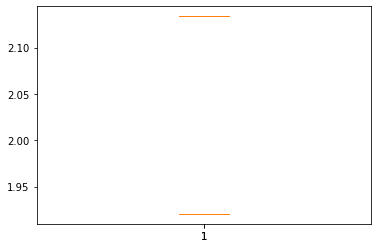

In [7]:
plt.boxplot(vanilla_rmse)
plt.boxplot(mc_rmse)
plt.show()

In [8]:
print(np.mean(vanilla_rmse), np.std(vanilla_rmse))
print(np.mean(vanilla_ll), np.std(vanilla_ll))
print(np.mean(mc_rmse), np.std(mc_rmse))
print(np.mean(mc_ll), np.std(mc_ll))

2.133824505073231 0.0
-2.187251657605248 0.0
1.92056296661301 0.0
-2.213643195007112 0.0
